In [1]:
import cv2
import numpy as np
import pandas as pd
import torch
import os
import time
import matplotlib.pyplot as plt
import math
import torch.nn.functional as F
import torchvision.transforms as tf
import torchvision.models as models
from torch.utils.data.sampler import WeightedRandomSampler
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from PIL import Image
from collections import OrderedDict

torch.cuda.empty_cache()

path = 'DATA/Images/'

In [2]:
###Image Prep

In [3]:
###Functions 

def splitter(dataset,split=(70,15,15),seed=None):

    assert sum(split)==100
    if seed != None:
        np.random.seed(seed)
    train_data = []
    valid_data = []
    test_data = []
        
    for i in range(0,len(dataset)):
      
        chance = np.random.randint(0,100)

        if chance < split[0]:
            train_data.append(i)
            
        elif chance >= split[0] and chance < (split[0]+split[1]):
            valid_data.append(i)
        
        elif chance >= (split[0]+split[1]) and chance < sum(split): 
            test_data.append(i)
            
        else: 
            print(chance)
    
   
  
    return dataset.iloc[train_data], dataset.iloc[valid_data], dataset.iloc[test_data]
        
    
def showRandomSamples(dataset,path='DATA/Images/',seed=42):
    
    pick = np.random.randint(0,len(dataset),size=1)
    
    fig = plt.figure()
    
    #ax = fig.subplots(1,4)
    
    #for i,i_img in enumerate(pick):
        
     #   ax = fig.add_subplot(1,1,(i+1))
    img = dataset[pick]['image']
    plt.imshow(img)
    
    return none

def dynDevice():
    if torch.cuda.device_count() == 0:
        device = 'cpu'
    elif torch.cuda.device_count() > 0:
        device = 'cuda'
        nDevice = torch.cuda.device_count()  #setup for later implementation of multi gpu parallel processing
    return device

print(dynDevice())

  
def inv_normalize(x):
    
    
    
    return x


def imageCount(dataset,labelheader):
    
    dataset_categories = dataset[labelheader].unique()
    cat_count = []
    total=len(dataset)
    for i in dataset_categories:
        cat_count.append((i,len(dataset[labelheader][dataset[labelheader]==i])))
    return (cat_count,total)



def weightsBalancedClasses(dataset,nclasses):     #images,classe                   
    count = [0] * nclasses                                                      
    for item in dataset:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight                                                               


def sampler_(dataset,labelheader):
    dataset_counts,num_samples = imageCount(dataset,labelheader)
    class_weights=[]
    lookup_table={}
    for i in dataset_counts:
        class_weights.append(num_samples/i[1])
        lookup_table[i[0]]=num_samples/i[1]

    output_dataset = [lookup_table[i[1]] for i in dataset[labelheader].iteritems()]#np.select(conditions, choices, default=None)
    
    #sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))
    #print(output_dataset)
    return torch.tensor(output_dataset,dtype=torch.float)





cuda


In [4]:
annotation_index = ['Garth_ML_index.csv','Gulda_ML_index.csv']

annotations = pd.DataFrame()

for index in annotation_index:
    annotations = annotations.append(pd.read_csv(index))
#annotations_good.drop(['Unusable', 'Moderately good'], axis=1, inplace=True)

print(len(annotations))
annotations = annotations[~(np.isnan(annotations['Unusable'])&np.isnan(annotations['Moderately good'])&np.isnan(annotations['Good-number of layers']))]
print(len(annotations))
annotations.head()

quality = np.array(np.zeros(len(annotations),dtype=np.float64))


for i in range(0,len(quality)):
    if not np.isnan(annotations['Unusable'].iloc[i]):
        quality[i]=0.0
    elif not np.isnan(annotations['Moderately good'].iloc[i]):
        quality[i]= 0.75
    elif not np.isnan(annotations['Good-number of layers'].iloc[i]):
        quality[i] = 1.0
#     else:
#         quality[i] = -1.0

def cats(x):
    if x == 0:
        return 'bad'
    if x == 0.5:
        return 'mediocre'
    if x == 1:
        return 'good'
    
annotations_class = annotations.copy()
annotations_class['quality'] = quality
annotations_class['cats'] = annotations_class['quality'].apply(cats)
annotations_class['cats'] = annotations_class['cats'].astype('category')

print(len(annotations_class))


imageCount(annotations_class,'quality')



27936
17201
17201


([(0.0, 9813), (0.75, 5029), (1.0, 2359)], 17201)

In [5]:
max(annotations_class['quality'])

1.0

In [6]:
print(annotations_class['cats'].cat.categories)
annotations_class_quality = annotations_class[(annotations_class['quality']>=0.9) | (annotations_class['quality']<=0.1)]
annotations_class_layers = annotations_class[annotations_class['quality']>=0.9]

print(len(annotations_class))
print(len(annotations_class_quality))
print(len(annotations_class_layers))



Index(['bad', 'good'], dtype='object')
17201
12172
2359


In [7]:
###Setup Model

In [8]:
# class TwoModelA(torch.nn.Module):
    
#     def __init__(self):
        
#         super().__init__()

#         self.conv1 = torch.nn.Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
#         self.conv2 = torch.nn.Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
#         self.conv3 = torch.nn.Conv2d(6, 9, kernel_size=(5, 5), stride=(1, 1))
#         self.fc1 = torch.nn.Linear(in_features=28*28*9, out_features=512, bias=True)
#         self.fc2 = torch.nn.Linear(in_features=512, out_features=128, bias=True)
#         self.fc3 = torch.nn.Linear(in_features=128, out_features=3, bias=True)
        

        

#     def forward(self,x):
        
#         x = F.elu(self.conv1(x))
#         x = F.elu(self.conv2(F.dropout(F.max_pool2d(x,kernel_size=2,stride=2),p=0.2)))
#         x = F.elu(self.conv3(F.dropout(F.max_pool2d(x,kernel_size=2,stride=2),p=0.2)))
#         x = F.max_pool2d(x,kernel_size=2,stride=2).view(-1,28*28*9)
#         x = F.elu(self.fc1(x))
#         x = F.relu(self.fc2(F.dropout(x,p=0.2)))
#         x = self.fc3(F.dropout(x,p=0.2))
#         return F.log_softmax(x,dim=1)
    
    


# modelA =TwoModelA()

# print(modelA)

# total=0
# for param in modelA.parameters():
#     total+=param.numel()
#     print(param.numel())

# print('________________')
# print(total)


# criterionA = torch.nn.CrossEntropyLoss() 
# optimizerA = torch.optim.AdamW(modelA.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001, amsgrad=True)




modelA = models.resnet18(pretrained=True)
#for param in modelA.parameters():
#    param.requires_grad = False

print(modelA)


modelA.conv1 = torch.nn.Conv2d(1, 64,kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


modelA.fc = torch.nn.Sequential(torch.nn.Linear(512, 512), #ALTERNATIVELY w ORdered Dic: nn.Sequential(OrderedDict([ ('conv1', nn.Conv2d(1,20,5)),('', nn.),...]))
                                 torch.nn.ReLU(),
                                 torch.nn.Dropout(0.4),
                                 torch.nn.Linear(512, 1))

total=0
for param in modelA.parameters():
    total+=param.numel()
    print(param.numel())

print('________________')
print(total)

print(modelA)



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
# class TwoModelB(torch.nn.Module):
    
#     def __init__(self):
        
#         super().__init__()

#         self.conv1 = torch.nn.Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
#         self.conv2 = torch.nn.Conv2d(6, 9, kernel_size=(5, 5), stride=(1, 1))
#         self.conv3 = torch.nn.Conv2d(9, 12, kernel_size=(5, 5), stride=(1, 1))
#         self.fc1 = torch.nn.Linear(in_features=28*28*12, out_features=512, bias=True)
#         self.fc2 = torch.nn.Linear(in_features=512, out_features=128, bias=True)
#         self.fc3 = torch.nn.Linear(in_features=128, out_features=1, bias=True)
        

        

#     def forward(self,x):
        
#         x = F.elu(self.conv1(x))
#         x = F.elu(self.conv2(F.dropout(F.max_pool2d(x,kernel_size=2,stride=2),p=0.2)))
#         x = F.elu(self.conv3(F.dropout(F.max_pool2d(x,kernel_size=2,stride=2),p=0.2)))
#         x = F.max_pool2d(x,kernel_size=2,stride=2).view(-1,28*28*12)
#         x = F.elu(self.fc1(x))
#         x = F.relu(self.fc2(F.dropout(x,p=0.2)))
#         x = self.fc3(F.dropout(x,p=0.2))
#         return x
    
    


# modelB = TwoModelB()

# print(modelB)

# total=0
# for param in modelB.parameters():
#     total+=param.numel()
#     print(param.numel())

# print('________________')
# print(total)

# criterionB = torch.nn.SmoothL1Loss()
# optimizerB = torch.optim.AdamW(modelB.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001, amsgrad=True)

modelB = models.resnet18(pretrained=True)
#for param in modelA.parameters():
#    param.requires_grad = False

print(modelB)


modelB.conv1 = torch.nn.Conv2d(1, 64,kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


modelB.fc = torch.nn.Sequential(torch.nn.Linear(512, 512), #ALTERNATIVELY w ORdered Dic: nn.Sequential(OrderedDict([ ('conv1', nn.Conv2d(1,20,5)),('', nn.),...]))
                                 torch.nn.ReLU(),
                                 torch.nn.Dropout(0.4),
                                 torch.nn.Linear(512, 1))

total=0
for param in modelB.parameters():
    total+=param.numel()
    print(param.numel())

print('________________')
print(total)

print(modelA)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
criterionA = torch.nn.SmoothL1Loss()
optimizerA = torch.optim.AdamW(modelA.parameters(), lr=0.00005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001, amsgrad=True)


criterionB = torch.nn.SmoothL1Loss()
optimizerB = torch.optim.AdamW(modelB.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001, amsgrad=True)


In [11]:
###Custom Data Loader

class customDs(Dataset):
    
    def __init__(self,dataset, mode,path = path, transforms=None):
        
        self.dataset = dataset
        self.transforms = transforms
        self.path = path
        self.mode = mode #quality or layers
        
        return None
    
    def __len__(self):
        return len(self.dataset)
      
    def __getitem__(self,idx):

        image = Image.open(self.path+self.dataset[idx][0]).getchannel('G')
        quality =self.dataset[idx][4]
        
       
        
        ##Encode for ML##
        
        if self.transforms!=None:
            image = self.transforms(image)
            
        if self.mode == 'quality':
            #assert quality==1, 'Dataset contains images of bad quality; training will fail'
            sample = (image,quality)
    
        elif self.mode =='layers':
            assert quality==1, 'Dataset contains images of bad quality; training will fail'
            n_layers = self.dataset[idx][3] if not np.isnan(self.dataset[idx][3]) else self.dataset[idx][2] if not np.isnan(self.dataset[idx][2]) else 0
            sample = (image,n_layers) 

        else:
            print('mode unknown; only accepts "quality" or "layers"')
        
        return sample

array([[48, 38, 33, ..., 33, 42, 37],
       [40, 35, 31, ..., 38, 42, 43],
       [40, 40, 38, ..., 37, 38, 45],
       ...,
       [51, 50, 56, ..., 42, 58, 43],
       [63, 51, 52, ..., 54, 44, 45],
       [60, 50, 60, ..., 43, 53, 46]], dtype=uint8)

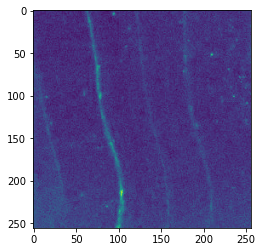

In [12]:

img = Image.open(path+'/Garth_A01_G006_0220[0,1].jpg').getchannel('G')
plt.imshow(img)
np.array(img)

#img = torch.tensor(img)
#comp = make_grid(torch.stack([img,img,img]))
#plt.imshow(np.transpose(comp.numpy(),(1,2,0)))

In [13]:
# plt.imshow(img.convert('L'))
# np.array(img.convert('L'))



In [14]:
#train-valid-test split = 70%, 15%, 15%
np.random.seed(42)


ann_trainA, ann_validA, ann_testA = splitter(annotations_class_quality,(70,15,15))
ann_trainB, ann_validB, ann_testB = splitter(annotations_class_layers,(70,15,15))

print(len(ann_trainA),len(ann_trainB))
print(len(ann_validA),len(ann_validB))
print(len(ann_testA),len(ann_testB))



8526 1656
1799 327
1847 376


In [15]:
tf_trainDs = customDs(ann_trainA.values,mode = 'quality',transforms=tf.Compose([
#                                               tf.Grayscale(num_output_channels=1),
                                               tf.RandomHorizontalFlip(p=0.5),
                                               tf.RandomVerticalFlip(p=0.5),
                                               tf.RandomPerspective(distortion_scale=0.05, p=0.10, interpolation=3),
                                               tf.RandomRotation(degrees=90, resample=False, expand=False, center=None),
                                               tf.Resize((256,256), interpolation=2),
                                               tf.ToTensor(),
#                                               tf.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                               ]))

                          

tf_validDs = customDs(ann_validA.values,mode = 'quality',transforms=tf.Compose([
#                                               tf.Grayscale(num_output_channels=1),
                               #                tf.RandomHorizontalFlip(p=0.5),
                               #                tf.RandomVerticalFlip(p=0.5),
                               #                tf.RandomPerspective(distortion_scale=0.1, p=0.1, interpolation=3),
                               #                tf.RandomRotation(degrees=20, resample=False, expand=False, center=None),
                                               tf.Resize((256,256), interpolation=2),
                                               tf.ToTensor(),
#                                               tf.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                               ]))

tf_testDs = customDs(ann_testA.values,mode = 'quality',transforms=tf.Compose([
#                                               tf.Grayscale(num_output_channels=1),
                                #               tf.RandomHorizontalFlip(p=0.5),
                                #               tf.RandomVerticalFlip(p=0.5),
                                #               tf.RandomPerspective(distortion_scale=0.1, p=0.1, interpolation=3),
                                #               tf.RandomRotation(degrees=20, resample=False, expand=False, center=None),
                                               tf.Resize((256,256), interpolation=2),
                                               tf.ToTensor(),
#                                               tf.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                               ]))


batchSize = 32

weightsA = sampler_(ann_trainA,"quality")                                    
samplerA = torch.utils.data.sampler.WeightedRandomSampler(weightsA,num_samples=len(weightsA),replacement=True)      
train_loader = DataLoader(tf_trainDs, batch_size = batchSize, sampler=samplerA, pin_memory=True, drop_last=True, num_workers=0)
valid_loader = DataLoader(tf_validDs, batch_size = batchSize, pin_memory=False, drop_last=True, shuffle=True, num_workers=0)
test_loader = DataLoader(tf_testDs, batch_size = batchSize, pin_memory=False, drop_last=True, shuffle=True, num_workers=0)

In [16]:
print(weightsA)

tensor([1.2348, 1.2348, 1.2348,  ..., 5.2597, 5.2597, 5.2597])


{0.0: 4257, 1.0: 4255, 'total': 8512}
{0.0: 1436, 1.0: 388, 'total': 1824}


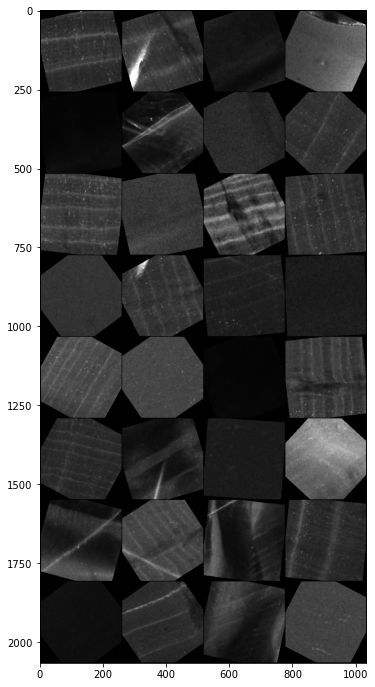

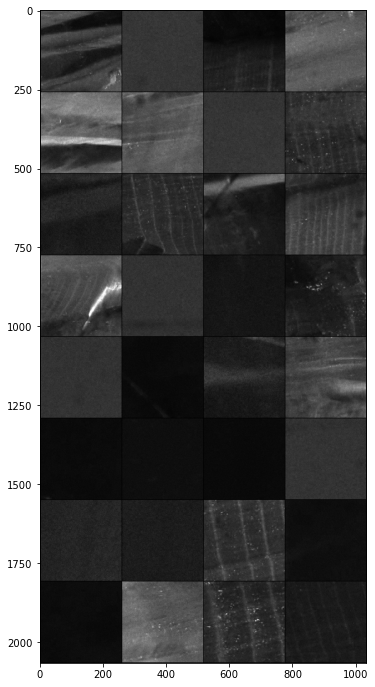

In [17]:
for img, label in train_loader:
    break
im = make_grid(img,nrow=4)
plt.figure(figsize=(12,12))
#print(label)
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

#count_dic = {i.item():0 for i in label.unique()}
count_dic = {}
total=0

for _, label in train_loader:
    for i in label.unique():
        if i.item() not in count_dic.keys():
            count_dic[i.item()]=0
    for key in count_dic.keys():
        count_dic[key]+=(label.numpy()==key).sum()
    total+=len(label)
count_dic["total"]=total
print(count_dic)


for img, label in test_loader:
    break
im = make_grid(img,nrow=4)
plt.figure(figsize=(12,12))
#print(label)
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

#count_dic = {i.item():0 for i in label.unique()}
count_dic = {}
total=0

for _, label in test_loader:
    for i in label.unique():
        if i.item() not in count_dic.keys():
            count_dic[i.item()]=0
    for key in count_dic.keys():
        count_dic[key]+=(label.numpy()==key).sum()
    total+=len(label)
count_dic["total"]=total
print(count_dic)

In [18]:
torch.cuda.empty_cache()
modelA.to(device = dynDevice())

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
epochs = 65
#epochs=10
training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []



for j in range(0,epochs): 
    
    epoch_start = time.time()
    i=0
    losses=0
    accuracies=0

    modelA.train()
    for img, label in train_loader:
        i+=1
        img, label = img.to(device = dynDevice()), label.to(device = dynDevice(), dtype=torch.float32)
        result = modelA.forward(img)
        loss = criterionA(result,label.view(-1,1))
        losses+=loss.item()
        
        #Accuracies: is the quality well constrained? if so, are the layers correctly determined? 
       # print(result.detach().cpu().numpy().flatten())
       # print(label.detach().cpu().numpy().flatten())
        accuracies+= 1-np.abs((result.detach().cpu().numpy().flatten() - label.detach().cpu().numpy().flatten())).mean().item()     
       
        #Update Model
        optimizerA.zero_grad()
        loss.backward()
        optimizerA.step()
       
    training_losses.append(losses/i) 
    training_accuracies.append(accuracies/i)
    training_end =time.time()

    #Validate
    i=0
    losses=0
    accuracies=0
    modelA.eval()
    with torch.no_grad():
        for img, label in valid_loader:
            i+=1
            img, label = img.to(device = dynDevice()), label.to(device = dynDevice(), dtype=torch.float32)
            result = modelA.forward(img)
            loss = criterionA(result,label.view(-1,1))
            losses+=loss.item()
            accuracies+= 1-np.abs((result.detach().cpu().numpy().flatten() - label.detach().cpu().numpy().flatten())).mean().item()     
#            if i%100 ==0:
#                print(f'Validation BATCH:{i}   LOSS:{loss.item()}   ACCURACY:{accuracies/(i*batchSize)}')
#                break

        
        validation_losses.append(losses/i)   
        validation_accuracies.append(accuracies/i)
        validation_end = time.time()
    
    print(f'The {j}th epoch took {(validation_end-epoch_start):.0f}s. \n    training took {(training_end-epoch_start):.0f}s \n    validation took {(validation_end-training_end):.0f}s')

    print(f'Losses were \n    training loss: {training_losses[-1]:.3f} \n    validation loss: {validation_losses[-1]:.3f}')
    
    print(f'Accuracies were \n    training accuracy: {training_accuracies[-1]:.3f} \n    validation accuracy: {validation_accuracies[-1]:.3f}\n\n\n\n\n')
    

    

The 0th epoch took 156s. 
    training took 141s 
    validation took 16s
Losses were 
    training loss: 0.049 
    validation loss: 0.016
Accuracies were 
    training accuracy: 0.769 
    validation accuracy: 0.883





The 1th epoch took 91s. 
    training took 84s 
    validation took 7s
Losses were 
    training loss: 0.024 
    validation loss: 0.009
Accuracies were 
    training accuracy: 0.847 
    validation accuracy: 0.926





The 2th epoch took 87s. 
    training took 80s 
    validation took 7s
Losses were 
    training loss: 0.017 
    validation loss: 0.009
Accuracies were 
    training accuracy: 0.880 
    validation accuracy: 0.927





The 3th epoch took 87s. 
    training took 80s 
    validation took 7s
Losses were 
    training loss: 0.015 
    validation loss: 0.006
Accuracies were 
    training accuracy: 0.894 
    validation accuracy: 0.944





The 4th epoch took 88s. 
    training took 81s 
    validation took 7s
Losses were 
    training loss: 0.013 
    val

In [20]:
img.shape

torch.Size([32, 1, 256, 256])

In [21]:
try:
    result
except:
    pass

torch.save(obj=modelA,f='MODELS/modelA_Garth-Gulda_bw_2quals_float_balanced_resnet18_wTL.pth')

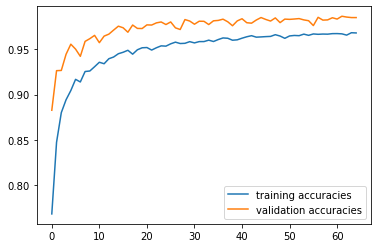

In [22]:


plt.plot(training_accuracies, label='training accuracies')
plt.plot(validation_accuracies,label='validation accuracies')
plt.legend()

plt.legend()
plt.savefig('resnet18_withTL_netA_floatQuality_used1.png',dpi=600, facecolor='w', edgecolor='b',
        orientation='portrait', format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

In [23]:
del modelA, train_loader, test_loader, valid_loader, loss
torch.cuda.empty_cache()

In [24]:
tf_trainDs = customDs(ann_trainB.values,mode = 'layers',transforms=tf.Compose([
                                         #      tf.Grayscale(num_output_channels=1),
                                               tf.RandomHorizontalFlip(p=0.5),
                                               tf.RandomVerticalFlip(p=0.5),
                                               tf.RandomPerspective(distortion_scale=0.05, p=0.10, interpolation=3),
                                               tf.RandomRotation(degrees=90, resample=False, expand=False, center=None),
                                               tf.Resize((256,256), interpolation=2),
                                               tf.ToTensor(),
#                                               tf.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                               ]))

                          

tf_validDs = customDs(ann_validB.values,mode = 'layers',transforms=tf.Compose([
                                 #              tf.Grayscale(num_output_channels=1),
                               #                tf.RandomHorizontalFlip(p=0.5),
                               #                tf.RandomVerticalFlip(p=0.5),
                               #                tf.RandomPerspective(distortion_scale=0.1, p=0.1, interpolation=3),
                               #                tf.RandomRotation(degrees=20, resample=False, expand=False, center=None),
                                               tf.Resize((256,256), interpolation=2),
                                               tf.ToTensor(),
#                                               tf.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                               ]))

tf_testDs = customDs(ann_testB.values,mode = 'layers',transforms=tf.Compose([
                                    #           tf.Grayscale(num_output_channels=1),
                                #               tf.RandomHorizontalFlip(p=0.5),
                                #               tf.RandomVerticalFlip(p=0.5),
                                #               tf.RandomPerspective(distortion_scale=0.1, p=0.1, interpolation=3),
                                #               tf.RandomRotation(degrees=20, resample=False, expand=False, center=None),
                                               tf.Resize((256,256), interpolation=2),
                                               tf.ToTensor(),
#                                               tf.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                               ]))



weightsB = sampler_(ann_trainB,"Good-number of layers")                                    
samplerB = torch.utils.data.sampler.WeightedRandomSampler(weightsB,num_samples=len(weightsB),replacement=True)      

batchSize = 32
train_loader = DataLoader(tf_trainDs, batch_size = batchSize, sampler = samplerB, pin_memory=True, drop_last=True,num_workers=0)
valid_loader = DataLoader(tf_validDs, batch_size = batchSize, pin_memory=True, drop_last=True, shuffle=False, num_workers=0)
test_loader = DataLoader(tf_testDs, batch_size = batchSize, pin_memory=True, drop_last=True, shuffle=False, num_workers=0)

{1.0: 113, 2.0: 127, 3.0: 114, 4.0: 120, 5.0: 121, 6.0: 113, 7.0: 102, 8.0: 113, 9.0: 124, 10.0: 120, 11.0: 116, 12.0: 121, 13.0: 115, 14.0: 113, 'total': 1632}
{2.0: 35, 3.0: 79, 4.0: 73, 5.0: 52, 6.0: 41, 7.0: 22, 8.0: 22, 9.0: 16, 10.0: 8, 12.0: 2, 1.0: 1, 11.0: 1, 'total': 352}


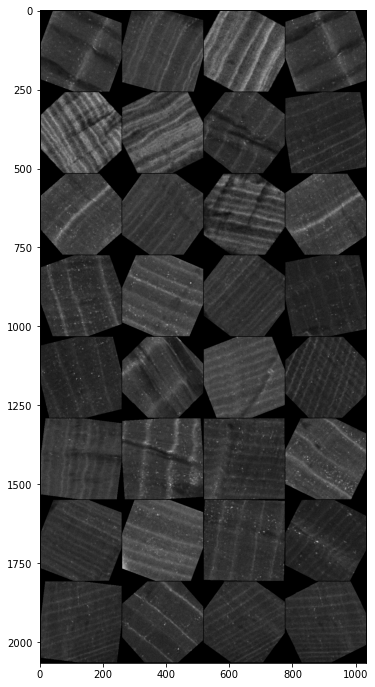

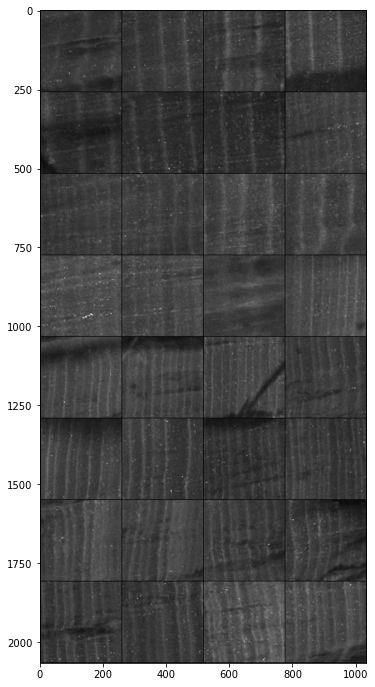

In [25]:
for img, label in train_loader:
    break
im = make_grid(img,nrow=4)
plt.figure(figsize=(12,12))
#print(label)
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

#count_dic = {i.item():0 for i in label.unique()}
count_dic = {}
total=0

for _, label in train_loader:
    for i in label.unique():
        if i.item() not in count_dic.keys():
            count_dic[i.item()]=0
    for key in count_dic.keys():
        count_dic[key]+=(label.numpy()==key).sum()
    total+=len(label)
count_dic["total"]=total
print(count_dic)


for img, label in test_loader:
    break
im = make_grid(img,nrow=4)
plt.figure(figsize=(12,12))
#print(label)
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

#count_dic = {i.item():0 for i in label.unique()}
count_dic = {}
total=0

for _, label in test_loader:
    for i in label.unique():
        if i.item() not in count_dic.keys():
            count_dic[i.item()]=0
    for key in count_dic.keys():
        count_dic[key]+=(label.numpy()==key).sum()
    total+=len(label)
count_dic["total"]=total
print(count_dic)

In [26]:


modelB.to(device = dynDevice())


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
epochs = 160
#epochs=100


training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []



for j in range(0,epochs): 
    
    epoch_start = time.time()
    i=0
    losses=0
    accuracies=0

    modelB.train()
    for img, label in train_loader:
        i+=1
        img, label = img.to(device = dynDevice()), label.to(device = dynDevice(), dtype=torch.float32)
        result = modelB(img)
        loss = criterionB(result,label.view(-1,1))
        losses+=loss.item()
        
        #Accuracies: is the quality well constrained? if so, are the layers correctly determined? 
        accuracies+= (result.detach().cpu().numpy().flatten().round() == label.detach().cpu().numpy().round()).sum()        

#        if i%100 ==0:
#            print(f'Training BATCH:{i}   LOSS:{loss.item()}   ACCURACY:{accuracies/i}')
#            break
        
        
        #Update Model
        optimizerB.zero_grad()
        loss.backward()
        optimizerB.step()
        

  
        
    training_losses.append(losses/i) 
    training_accuracies.append(accuracies/(i*batchSize))
    training_end =time.time()

    #Validate
    i=0
    losses=0
    accuracies=[0,0,0]
    modelB.eval()
    with torch.no_grad():
        for img, label in valid_loader:
            i+=1
            img, label = img.to(device = dynDevice()), label.to(device = dynDevice(),dtype=torch.float32)
            result = modelB(img)
            loss = criterionB(result,label.view(-1,1))
            losses+=loss.item()
            accuracies[0]+= (result.detach().cpu().numpy().flatten().round() == label.detach().cpu().numpy().round()).sum()
            accuracies[1]+= (result.detach().cpu().numpy().flatten().round() == (label.detach().cpu().numpy().round())-1).sum()
            accuracies[2]+= (result.detach().cpu().numpy().flatten().round() == (label.detach().cpu().numpy().round())+1).sum()
            
            
            
#            if i%100 ==0:
#                print(f'Training BATCH:{i}   LOSS:{loss.item()}   ACCURACY:{accuracies/i}')
#                break

        
        validation_losses.append(losses/i)   
        validation_accuracies.append(np.array(accuracies)/(i*batchSize))
        validation_end = time.time()
    
    print(f'The {j}th epoch took {(validation_end-epoch_start):.0f}s. \n    training took {(training_end-epoch_start):.0f}s \n    validation took {(validation_end-training_end):.0f}s')

    print(f'Losses were \n    training loss: {training_losses[-1]:.3f} \n    validation loss: {validation_losses[-1]:.3f}')
    
    print(f'Accuracies were \n    training accuracy: {training_accuracies[-1]:.3f} \n    validation accuracy: {validation_accuracies[-1][0]:.3f}')
    
    print(f'Accuracies were \n    underestimated by 1 layer: {validation_accuracies[-1][1]:.3f} \n    overestimated by 1 layer: {validation_accuracies[-1][2]:.3f}\n\n\n\n')

The 0th epoch took 21s. 
    training took 19s 
    validation took 2s
Losses were 
    training loss: 2.695 
    validation loss: 1.308
Accuracies were 
    training accuracy: 0.142 
    validation accuracy: 0.184
Accuracies were 
    underestimated by 1 layer: 0.094 
    overestimated by 1 layer: 0.219




The 1th epoch took 21s. 
    training took 19s 
    validation took 2s
Losses were 
    training loss: 1.023 
    validation loss: 0.975
Accuracies were 
    training accuracy: 0.240 
    validation accuracy: 0.300
Accuracies were 
    underestimated by 1 layer: 0.163 
    overestimated by 1 layer: 0.175




The 2th epoch took 21s. 
    training took 19s 
    validation took 2s
Losses were 
    training loss: 0.866 
    validation loss: 0.740
Accuracies were 
    training accuracy: 0.292 
    validation accuracy: 0.344
Accuracies were 
    underestimated by 1 layer: 0.191 
    overestimated by 1 layer: 0.197




The 3th epoch took 21s. 
    training took 19s 
    validation took 2s

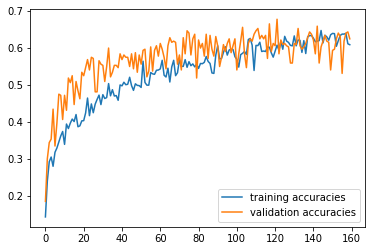

In [28]:
validation_accuracies1=[i[0] for i in validation_accuracies]


plt.plot(training_accuracies, label='training accuracies')
plt.plot(validation_accuracies1,label='validation accuracies')
plt.legend()
plt.savefig('resnet18_finerMesh2_floatQuality_noTL_netB.png',dpi=600, facecolor='w', edgecolor='b',
        orientation='portrait', format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)

In [31]:
torch.save(obj=modelB,f='MODELS/modelB_Garth-Gulda_bw_float_balanced_resnet18_wTL.pth')


In [33]:
modelA = torch.load('MODELS/modelA_Garth-Gulda_bw_2quals_float_balanced_resnet18_wTL.pth',map_location=torch.device('cuda:0'))
modelB = torch.load('MODELS/modelB_Garth-Gulda_bw_float_balanced_resnet18_wTL.pth',map_location=torch.device('cuda:0'))

In [34]:
tf_testDs = customDs(ann_testA.values,mode = 'quality',transforms=tf.Compose([
#                                               tf.Grayscale(num_output_channels=1),
                                #               tf.RandomHorizontalFlip(p=0.5),
                                #               tf.RandomVerticalFlip(p=0.5),
                                #               tf.RandomPerspective(distortion_scale=0.1, p=0.1, interpolation=3),
                                #               tf.RandomRotation(degrees=20, resample=False, expand=False, center=None),
                                               tf.Resize((256,256), interpolation=2),
                                               tf.ToTensor(),
#                                               tf.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                               ]))

batchSize = 32
test_loader = DataLoader(tf_testDs, batch_size = batchSize, pin_memory=True, drop_last=True, shuffle=True, num_workers=0)


In [35]:
# modelA = torch.load('MODELS/modelA_bw_floatQuality_resnet18_withTL.pth',map_location=torch.device('cuda:0'))
# modelB = torch.load('MODELS/modelB_bw_floatQuality_resnet18_withTL.pth',map_location=torch.device('cuda:0'))

In [36]:
test_losses=[]
test_accuracies=[]
i=0
losses=0
accuracies=0
modelA.eval()
with torch.no_grad():
    for img, label in test_loader:
        i+=1
        img, label = img.to(device = dynDevice()), label.to(device = dynDevice(), dtype=torch.float32)
        result = modelA.forward(img)
        loss = criterionA(result,label.view(-1,1))
        losses+=loss.item()
        accuracies+= 1-np.abs((result.detach().cpu().numpy().flatten() - label.detach().cpu().numpy().flatten())).mean().item()     
   
    test_losses.append(losses/i)   
    test_accuracies.append(accuracies/i)
    
print(f'Losses were \n     test loss: {test_losses[-1]:.3f}')
print(f'Accuracies were \n    test accuracy: {test_accuracies[-1]:.3f}\n\n\n')

Losses were 
     test loss: 0.003
Accuracies were 
    test accuracy: 0.984





In [37]:
tf_testDs = customDs(ann_testB.values,mode = 'layers',transforms=tf.Compose([
                                    #           tf.Grayscale(num_output_channels=1),
                                #               tf.RandomHorizontalFlip(p=0.5),
                                #               tf.RandomVerticalFlip(p=0.5),
                                #               tf.RandomPerspective(distortion_scale=0.1, p=0.1, interpolation=3),
                                #               tf.RandomRotation(degrees=20, resample=False, expand=False, center=None),
                                               tf.Resize((256,256), interpolation=2),
                                               tf.ToTensor(),
#                                               tf.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                               ]))


batchSize = 128
test_loader = DataLoader(tf_testDs, batch_size = batchSize, pin_memory=True, drop_last=True, shuffle=False, num_workers=0)

In [38]:
#Validate

test_losses=[]
test_accuracies=[]
i=0
losses=0
accuracies=[0,0,0]
modelB.eval()
with torch.no_grad():
    for img, label in test_loader:
        i+=1
        img, label = img.to(device = dynDevice()), label.to(device = dynDevice(),dtype=torch.float32)
        result = modelB(img)
        loss = criterionB(result,label.view(-1,1))
        losses+=loss.item()
        accuracies[0]+= (result.detach().cpu().numpy().flatten().round() == label.detach().cpu().numpy().round()).sum()
        accuracies[1]+= (result.detach().cpu().numpy().flatten().round() == (label.detach().cpu().numpy().round())-1).sum()
        accuracies[2]+= (result.detach().cpu().numpy().flatten().round() == (label.detach().cpu().numpy().round())+1).sum()



#            if i%100 ==0:
#                print(f'Training BATCH:{i}   LOSS:{loss.item()}   ACCURACY:{accuracies/i}')
#                break


    test_losses.append(losses/i)   
    test_accuracies.append(np.array(accuracies)/(i*batchSize))

    

print(f'Losses were \n    test loss: {test_losses[-1]:.3f}')

print(f'Accuracies were \n    test accuracy: {test_accuracies[-1][0]:.3f}')

print(f'Accuracies were \n    underestimated by 1 layer: {test_accuracies[-1][1]:.3f} \n    overestimated by 1 layer: {test_accuracies[-1][2]:.3f}\n\n\n\n')

Losses were 
    test loss: 0.184
Accuracies were 
    test accuracy: 0.645
Accuracies were 
    underestimated by 1 layer: 0.137 
    overestimated by 1 layer: 0.180




